In [1]:
import logging

# to be added to requirements.txt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from project_panaroma import Stitcher
from recommender import HierarchicalClustering, StitcherWithRecommender


In [2]:

# logging.basicConfig(level=logging.INFO)


# class HierarchicalClustering:
#     def __init__(self, distance_matrix):
#         self.distance_matrix = distance_matrix.copy()
#         self.num_images = distance_matrix.shape[0]
#         self.clusters = [[i] for i in range(self.num_images)]
#         self.distances = self._convert_similarity_to_distance(distance_matrix)

#     def _convert_similarity_to_distance(self, similarity_matrix):
#         # Convert similarity scores to distances
#         # Adding epsilon to avoid division by zero
#         epsilon = 1e-5
#         distance_matrix = 1 / (similarity_matrix + epsilon)
#         np.fill_diagonal(distance_matrix, 0)
#         return distance_matrix

#     def fit(self, num_clusters=1):
#         while len(self.clusters) > num_clusters:
#             # Find the two clusters with the smallest distance
#             min_distance = np.inf
#             x, y = -1, -1
#             for i in range(len(self.clusters)):
#                 for j in range(i + 1, len(self.clusters)):
#                     dist = self._cluster_distance(self.clusters[i], self.clusters[j])
#                     if dist < min_distance:
#                         min_distance = dist
#                         x, y = i, j
#             if x == -1 or y == -1:
#                 break  # No more clusters to merge
#             # Merge clusters x and y
#             self.clusters[x].extend(self.clusters[y])
#             del self.clusters[y]
#             logging.info(
#                 f"Merged clusters {x} and {y}, new cluster: {self.clusters[x]}"
#             )
#         return self.clusters

#     def _cluster_distance(self, cluster1, cluster2):
#         # Compute the average linkage distance between two clusters
#         distances = [self.distances[i][j] for i in cluster1 for j in cluster2]
#         return np.mean(distances)


# class StitcherWithRecommender(Stitcher):
#     def compute_pairwise_similarities(self):
#         num_images = len(self.input_images)
#         similarity_matrix = np.zeros((num_images, num_images))

#         for i in range(num_images):
#             kp1, des1 = self.feature_points_and_descriptors[i]
#             for j in range(i + 1, num_images):
#                 kp2, des2 = self.feature_points_and_descriptors[j]
#                 good_matches = self.match_features_call(des1, des2)
#                 similarity_score = len(good_matches)
#                 similarity_matrix[i, j] = similarity_score
#                 similarity_matrix[j, i] = similarity_score  # Symmetric matrix
#                 print(
#                     f"Similarity between image {i+1} and image {j+1}: {similarity_score} good matches"
#                 )

#         return similarity_matrix

#     def plot_distance_matrix_heatmap(self, distance_matrix):
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
#                     xticklabels=[f"Image {i+1}" for i in range(distance_matrix.shape[0])],
#                     yticklabels=[f"Image {i+1}" for i in range(distance_matrix.shape[0])])
#         plt.title("Distance Matrix Heatmap")
#         plt.xlabel("Images")
#         plt.ylabel("Images")
#         plt.show()
    
#     def generate_dendrogram(self, similarity_matrix):
#         # Convert the similarity matrix to a distance matrix
#         epsilon = 1e-5  # Small value to prevent division by zero
#         distance_matrix = 1 / (similarity_matrix + epsilon)
#         np.fill_diagonal(distance_matrix, 0)  # Ensure the diagonal is zero

#         # Convert the distance matrix to condensed form
#         condensed_distance = squareform(distance_matrix)

#         # Generate the linkage matrix using average linkage
#         linked = linkage(condensed_distance, method="average")

#         fig, ax = plt.subplots(figsize=(10, 7))
#         dendrogram_data = dendrogram(
#             linked,
#             labels=[f"Image {i+1}" for i in range(similarity_matrix.shape[0])],
#             ax=ax,
#         )
#         plt.title("Dendrogram of Image Similarities")
#         plt.xlabel("Images")
#         plt.ylabel("Distance")

#         # Load images and display them below the dendrogram
#         num_labels = len(dendrogram_data["ivl"])
#         image_height = 0.1  # Adjust as needed

#         # Get the x positions of the leaves
#         xlbls = ax.get_xticks()
#         xlbls = ax.get_xticks()

#         for i, label in enumerate(dendrogram_data["ivl"]):
#             image_index = int(label.split()[-1]) - 1
#             img = cv2.cvtColor(self.input_images[image_index], cv2.COLOR_BGR2RGB)
#             img = cv2.resize(img, (50, 50))

#             # Get the x position of the label
#             x = xlbls[i]
#             y = 0  # y-position can be zero as we're only interested in x

#             # Transform x position from data to figure coordinates
#             trans = ax.transData.transform((x, y))
#             inv = fig.transFigure.inverted()
#             x_fig, y_fig = inv.transform(trans)

#             # Width of each image in figure coordinates
#             width = (
#                 1 / num_labels * 0.8
#             )  # Adjust 0.8 to increase spacing between images
#             x_fig_centered = x_fig - width / 2

#             # Add new axes at the calculated position
#             img_ax = fig.add_axes(
#                 [x_fig_centered, 0.01, width, image_height], anchor="S", zorder=1
#             )
#             img_ax.imshow(img)
#             img_ax.axis("off")

#         plt.subplots_adjust(bottom=0.3)  # Adjust to make space for images
#         plt.show()

#     def recommend_images(self, num_clusters=1):
#         similarity_matrix = self.compute_pairwise_similarities()
#         self.generate_dendrogram(similarity_matrix)  # dendrogram before clustering
#         hc = HierarchicalClustering(similarity_matrix)
#         clusters = hc.fit(num_clusters=num_clusters)
#         recommendations = []
#         for idx, cluster in enumerate(clusters):
#             print(f"Cluster {idx + 1}: {[i + 1 for i in cluster]}")
#             recommendations.append([self.input_images[i] for i in cluster])
#         return recommendations

#     def stitch_recommended_images(self, recommended_image_groups):
#         for idx, image_group in enumerate(recommended_image_groups):
#             self.input_images = image_group
#             self.feature_points_and_descriptors = []
#             self.detect_keypoints_and_descriptors()
#             self.stitch3_with_post()
#             print(f"Stitched panorama for cluster {idx + 1} saved.")
            
            
#     # More methods feature engineering
#     def get_consolidated_feature_vectors(self):
#         """Consolidates feature vectors, flattening and concatenating descriptors for each image."""
#         feature_vectors = []

#         for _, descriptors in self.feature_points_and_descriptors:
#             if descriptors is not None:
#                 # Truncate or pad to ensure `sift_nfeatures` descriptors
#                 if descriptors.shape[0] >= self.sift_nfeatures:
#                     truncated_descriptors = descriptors[:self.sift_nfeatures]
#                 else:
#                     padded_descriptors = np.zeros((self.sift_nfeatures, descriptors.shape[1]))
#                     padded_descriptors[:descriptors.shape[0], :] = descriptors
#                     truncated_descriptors = padded_descriptors

#                 # Flatten descriptors for this image and add to feature vectors
#                 flattened_descriptors = truncated_descriptors.flatten()
#                 feature_vectors.append(flattened_descriptors)

#         # Stack the flattened feature vectors from all images into a 2D array
#         consolidated_features = np.vstack(feature_vectors)
#         return consolidated_features
        
#     def perform_pca(self, n_components=2):
#         """Performs PCA on the consolidated feature vectors with a specified number of components."""
#         features = self.get_consolidated_feature_vectors()
#         pca = PCA(n_components=n_components)
#         pca_result = pca.fit_transform(features)
#         return pca_result

#     def plot_pca_feature_space(self, kmeans_labels=None):
#         """
#         Plots the 2D PCA projection of image feature vectors.
        
#         Parameters:
#         - kmeans_labels: Optional K-means cluster labels to color-code the plot.
#         """
#         # Perform PCA with 2 components for 2D visualization
#         pca_result = self.perform_pca(n_components=2)

#         # Define colors for each cluster if K-means labels are provided
#         if kmeans_labels is not None:
#             unique_labels = set(kmeans_labels)
#             colors = plt.cm.get_cmap("tab10", len(unique_labels))  # Use color map for distinct colors
#         else:
#             colors = plt.cm.get_cmap("tab10", 1)  # Default color if no labels are provided

#         # Plot the 2D feature space
#         plt.figure(figsize=(10, 8))

#         for i in range(pca_result.shape[0]):
#             label = kmeans_labels[i] if kmeans_labels is not None else 0
#             color = colors(label)
#             plt.scatter(pca_result[i, 0], pca_result[i, 1], s=100, color=color, alpha=0.7)
#             plt.text(pca_result[i, 0], pca_result[i, 1], f"Image {i+1}",
#                      fontsize=9, ha="center", va="center")

#         plt.title("2D PCA of Image Feature Space")
#         plt.xlabel("PCA Component 1")
#         plt.ylabel("PCA Component 2")
#         plt.show()

#     def apply_kmeans(self, num_components_pca = 10, num_clusters=5):
#         """Applies K-means clustering on the consolidated feature vectors and returns cluster labels."""
#         features = self.get_consolidated_feature_vectors()
        
#         pca_features = self.perform_pca(n_components=num_components_pca)
#         kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#         cluster_labels = kmeans.fit_predict(pca_features)
#         return cluster_labels
    
#     def plot_kmeans_elbow_curve(self, max_k=10, num_components_pca=10):
#         """
#         Plots the elbow curve for K-means clustering by varying the number of clusters.

#         Parameters:
#         - max_k: Maximum number of clusters to test (default is 10).
#         - num_components_pca: Number of PCA components to use for dimensionality reduction before K-means.
#         """
#         features = self.get_consolidated_feature_vectors()
#         pca_features = self.perform_pca(n_components=num_components_pca)

#         # Calculate inertia for different values of k
#         inertia_values = []
#         k_values = range(1, max_k + 1)
        
#         for k in k_values:
#             kmeans = KMeans(n_clusters=k, random_state=42)
#             kmeans.fit(pca_features)
#             inertia_values.append(kmeans.inertia_)
#             logging.info(f"K={k}, Inertia={kmeans.inertia_}")

#         # Plot the elbow curve
#         plt.figure(figsize=(10, 6))
#         plt.plot(k_values, inertia_values, marker='o')
#         plt.title("Elbow Curve for K-means Clustering")
#         plt.xlabel("Number of Clusters (k)")
#         plt.ylabel("Inertia (Sum of Squared Distances)")
#         plt.xticks(k_values)
#         plt.grid(True)
#         plt.show()
    
#     def show_clustered_images(self, kmeans_labels, num_clusters):
#         """
#         Displays images that were clustered together based on the K-means clustering labels.

#         Parameters:
#         - kmeans_labels: List or array of cluster labels for each image, obtained from K-means clustering.
#         - num_clusters: The number of clusters to display.
#         """
#         for cluster_id in range(num_clusters):
#             cluster_indices = [i for i, label in enumerate(kmeans_labels) if label == cluster_id]
#             cluster_images = [self.input_images[i] for i in cluster_indices]

#             # Determine the grid size based on the number of images in the cluster
#             n_images = len(cluster_images)
#             cols = min(n_images, 5)  # Limit to 5 images per row
#             rows = (n_images // cols) + (n_images % cols > 0)

#             fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
#             fig.suptitle(f"Cluster {cluster_id + 1}", fontsize=16)
#             axs = axs.flatten() if n_images > 1 else [axs]  # Flatten axs for easy indexing

#             for idx, img in enumerate(cluster_images):
#                 axs[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#                 axs[idx].axis('off')

#             # Hide any unused subplots
#             for j in range(n_images, rows * cols):
#                 axs[j].axis('off')

#             plt.tight_layout()
#             plt.show()


In [3]:
stitcher1 = StitcherWithRecommender()
stitcher1.input_dir = 'data/gallery'
stitcher1.read_input_dir()

Found 18 images in the input directory.


# Feature Engineering

In [4]:
stitcher1.sift_nfeatures = 200               # Configure how many keypoints to detect
stitcher1.plot = False
stitcher1.detect_keypoints_and_descriptors()

Detected 200 keypoints in image 1 using SIFT.
Detected 200 keypoints in image 2 using SIFT.
Detected 200 keypoints in image 3 using SIFT.
Detected 200 keypoints in image 4 using SIFT.
Detected 205 keypoints in image 5 using SIFT.
Detected 200 keypoints in image 6 using SIFT.
Detected 201 keypoints in image 7 using SIFT.
Detected 200 keypoints in image 8 using SIFT.
Detected 201 keypoints in image 9 using SIFT.
Detected 200 keypoints in image 10 using SIFT.
Detected 200 keypoints in image 11 using SIFT.
Detected 200 keypoints in image 12 using SIFT.
Detected 200 keypoints in image 13 using SIFT.
Detected 200 keypoints in image 14 using SIFT.
Detected 201 keypoints in image 15 using SIFT.
Detected 200 keypoints in image 16 using SIFT.
Detected 200 keypoints in image 17 using SIFT.
Detected 200 keypoints in image 18 using SIFT.
Feature detection completed.


In [5]:
feature_set = stitcher1.get_consolidated_feature_vectors()
feature_set.shape

(18, 25600)

- the above shape is (no.of images, no. of features * 128)

# PCA - Dimensionality Reduction

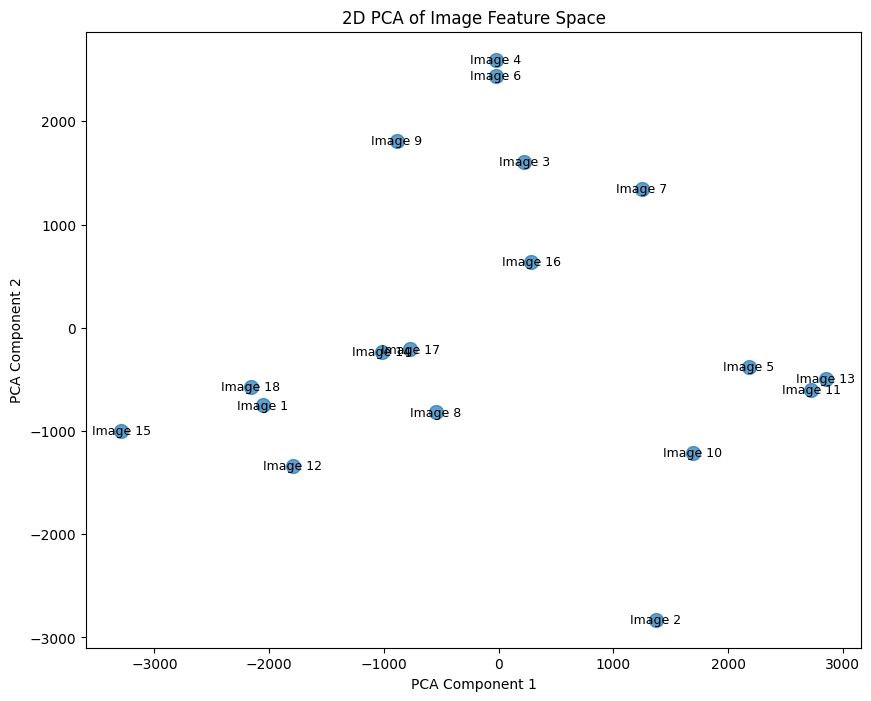

In [6]:
stitcher1.plot_pca_feature_space()

# K-means clustering

INFO:root:K=1, Inertia=182650144.0
INFO:root:K=2, Inertia=144020000.0
INFO:root:K=3, Inertia=115223792.0
INFO:root:K=4, Inertia=91729376.0
INFO:root:K=5, Inertia=70786064.0
INFO:root:K=6, Inertia=60301216.0
INFO:root:K=7, Inertia=45202768.0


INFO:root:K=8, Inertia=38682068.0
INFO:root:K=9, Inertia=33027744.0
INFO:root:K=10, Inertia=23971464.0


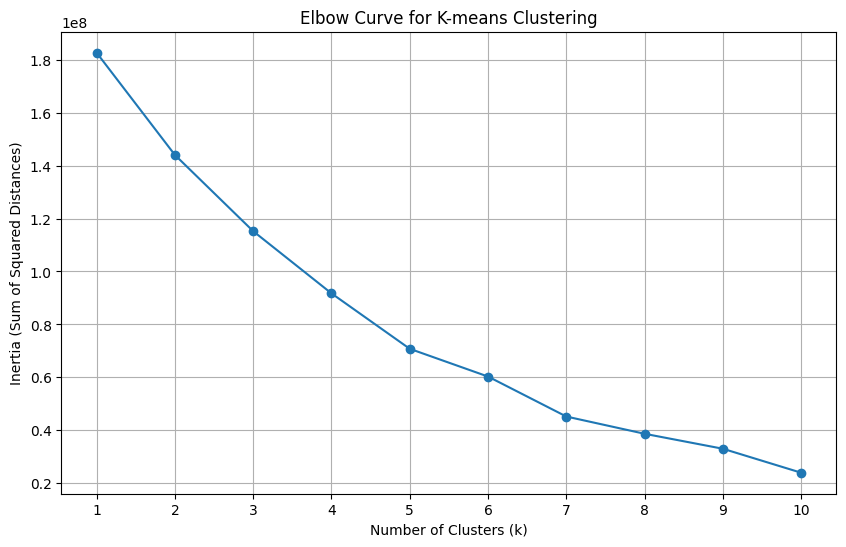

In [7]:
stitcher1.plot_kmeans_elbow_curve(max_k=10, num_components_pca=5)

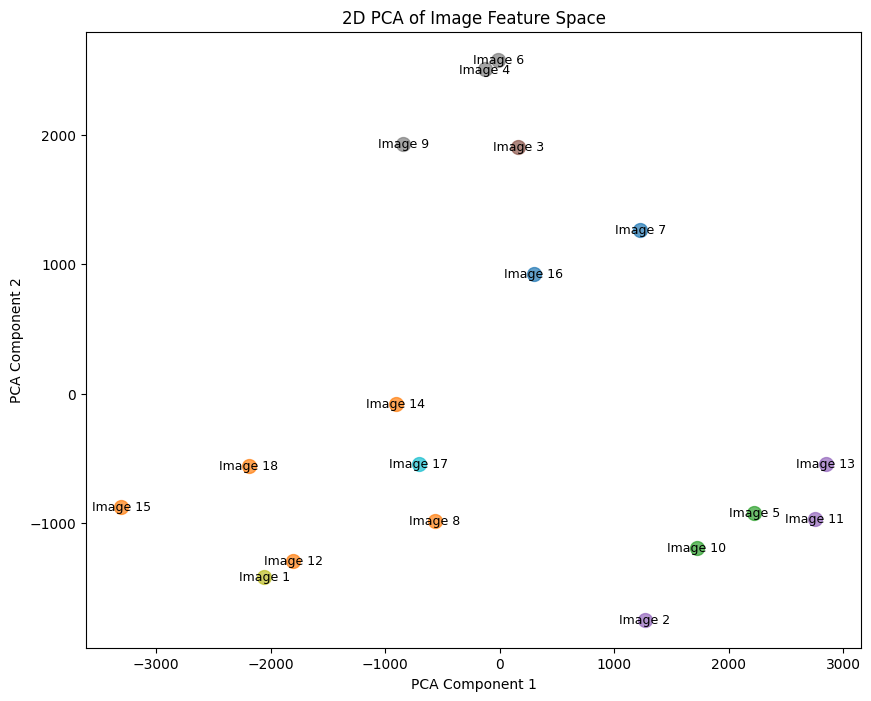

In [8]:
cluster_labels = stitcher1.apply_kmeans(
                                    num_clusters=8, 
                                    num_components_pca=5
                                    )

stitcher1.plot_pca_feature_space(kmeans_labels=cluster_labels)

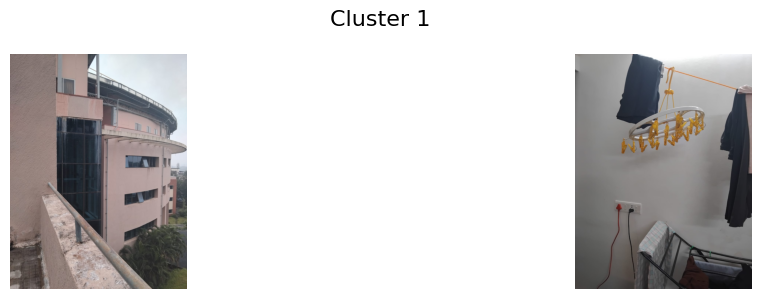

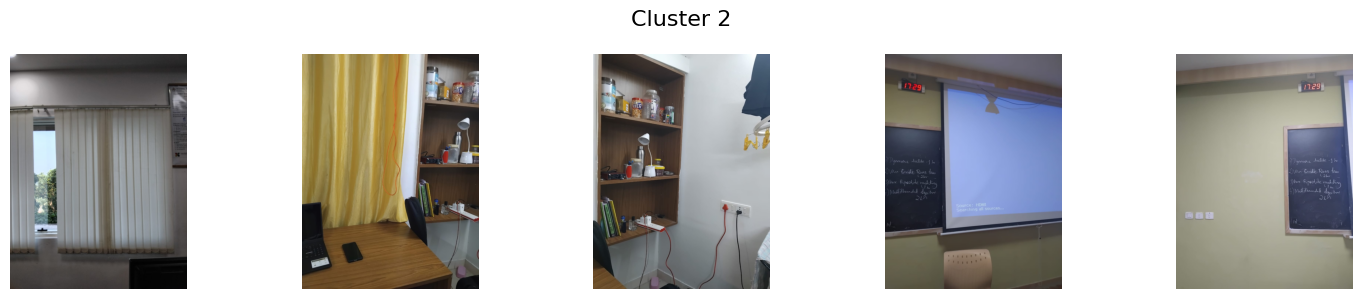

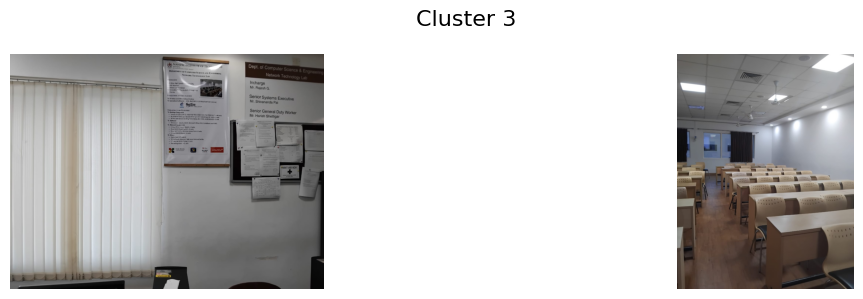

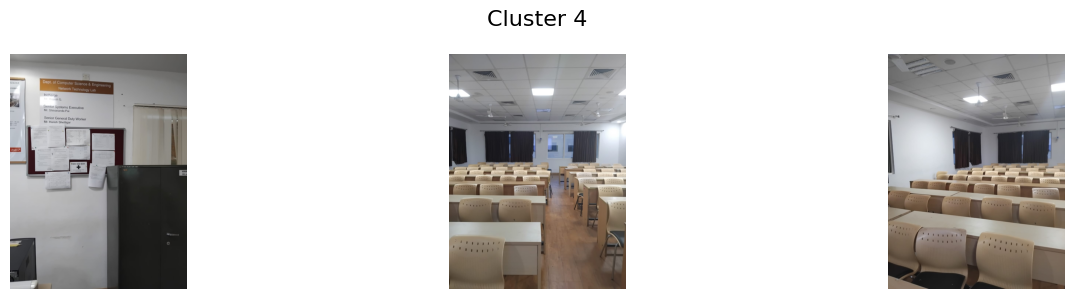

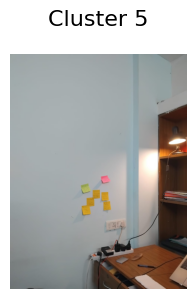

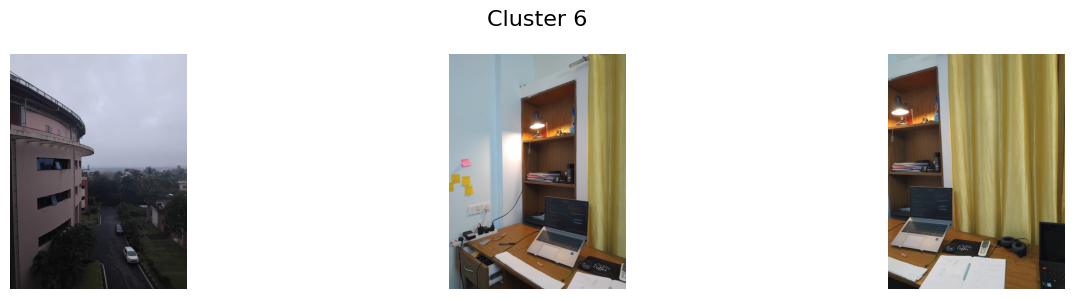

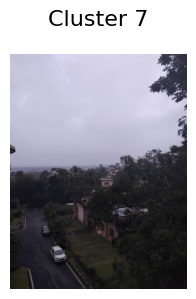

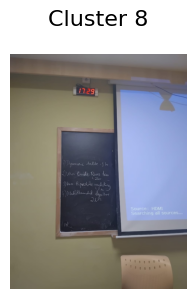

In [9]:
stitcher1.show_clustered_images(cluster_labels, num_clusters=len(set(cluster_labels)))

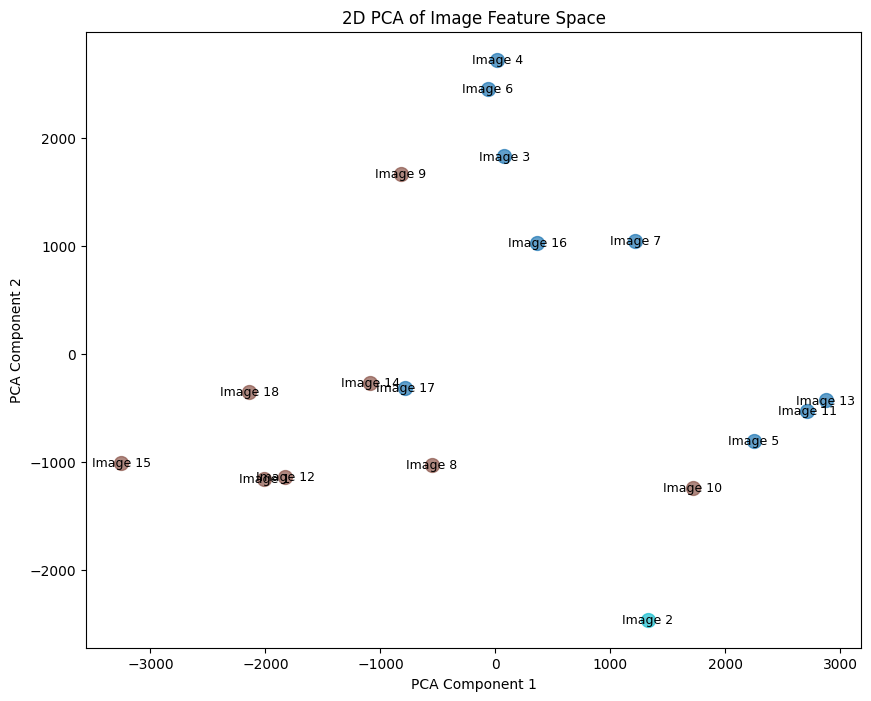

In [10]:
cluster_labels = stitcher1.apply_kmeans(num_clusters=3, num_components_pca=5)
stitcher1.plot_pca_feature_space(kmeans_labels=cluster_labels)


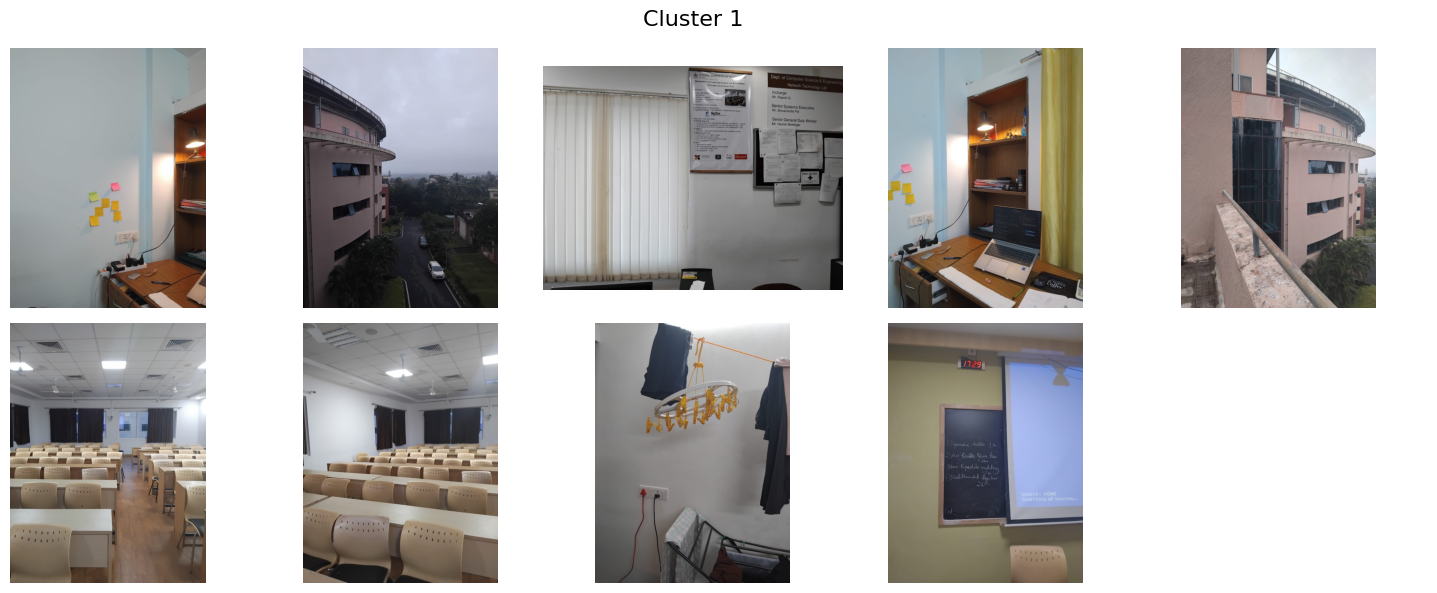

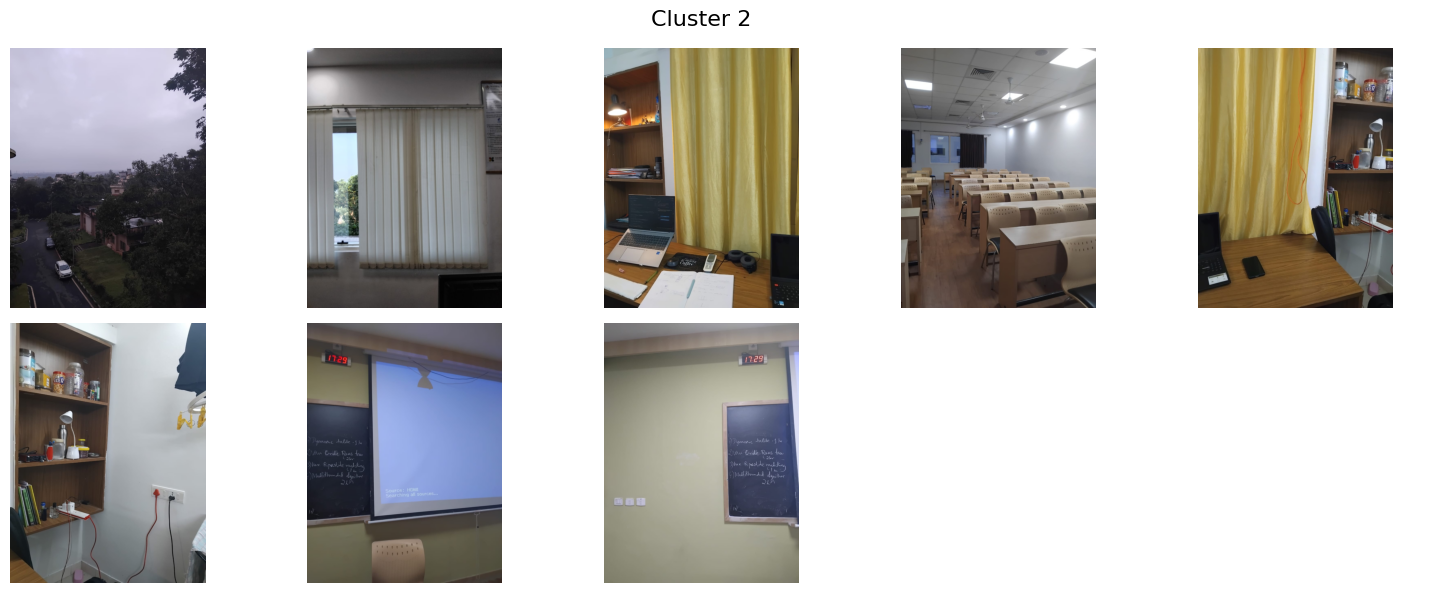

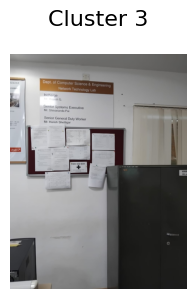

In [11]:
stitcher1.show_clustered_images(cluster_labels, num_clusters=3)

# Hierarchial Agglomerative Clustering

In [12]:
# Assuming `stitcher` is an instance of the Stitcher class
stitcher = StitcherWithRecommender()
stitcher.input_dir = "data/gallery_of_3s"
stitcher.output_dir = "data/gallery_of_3s_outputs"
stitcher.plot = False

stitcher.read_input_dir()
stitcher.detect_keypoints_and_descriptors()

Found 9 images in the input directory.
Detected 1659 keypoints in image 1 using SIFT.
Detected 1213 keypoints in image 2 using SIFT.
Detected 2921 keypoints in image 3 using SIFT.
Detected 971 keypoints in image 4 using SIFT.
Detected 1270 keypoints in image 5 using SIFT.
Detected 1391 keypoints in image 6 using SIFT.
Detected 812 keypoints in image 7 using SIFT.
Detected 470 keypoints in image 8 using SIFT.
Detected 357 keypoints in image 9 using SIFT.
Feature detection completed.


In [13]:
# Compute the similarity matrix for the images
similarity_matrix = stitcher.compute_pairwise_similarities()

# Create an instance of HierarchicalClustering to convert similarity to distance
hc = HierarchicalClustering(similarity_matrix)
distance_matrix = hc._convert_similarity_to_distance(similarity_matrix)

Found 200 good matches after ratio test.
Similarity between image 1 and image 2: 200 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 3: 36 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 4: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 5: 21 good matches
Found 22 good matches after ratio test.
Similarity between image 1 and image 6: 22 good matches
Found 8 good matches after ratio test.
Similarity between image 1 and image 7: 8 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 8: 25 good matches
Found 26 good matches after ratio test.
Similarity between image 1 and image 9: 26 good matches
Found 294 good matches after ratio test.
Similarity between image 2 and image 3: 294 good matches
Found 31 good matches after ratio test.
Similarity between image 2 and image 4: 31 good matches
Found 46 good matches after ratio test

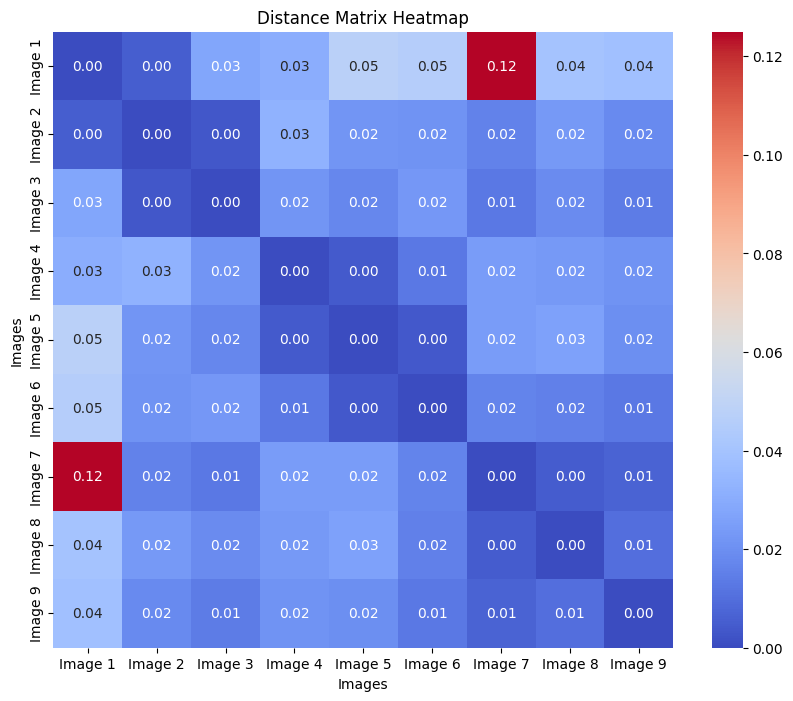

In [14]:

# Plot the heatmap of the initial distance matrix
stitcher.plot_distance_matrix_heatmap(distance_matrix)


Found 200 good matches after ratio test.
Similarity between image 1 and image 2: 200 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 3: 36 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 4: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 5: 21 good matches
Found 22 good matches after ratio test.
Similarity between image 1 and image 6: 22 good matches
Found 8 good matches after ratio test.
Similarity between image 1 and image 7: 8 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 8: 25 good matches
Found 26 good matches after ratio test.
Similarity between image 1 and image 9: 26 good matches
Found 294 good matches after ratio test.
Similarity between image 2 and image 3: 294 good matches
Found 31 good matches after ratio test.
Similarity between image 2 and image 4: 31 good matches
Found 46 good matches after ratio test

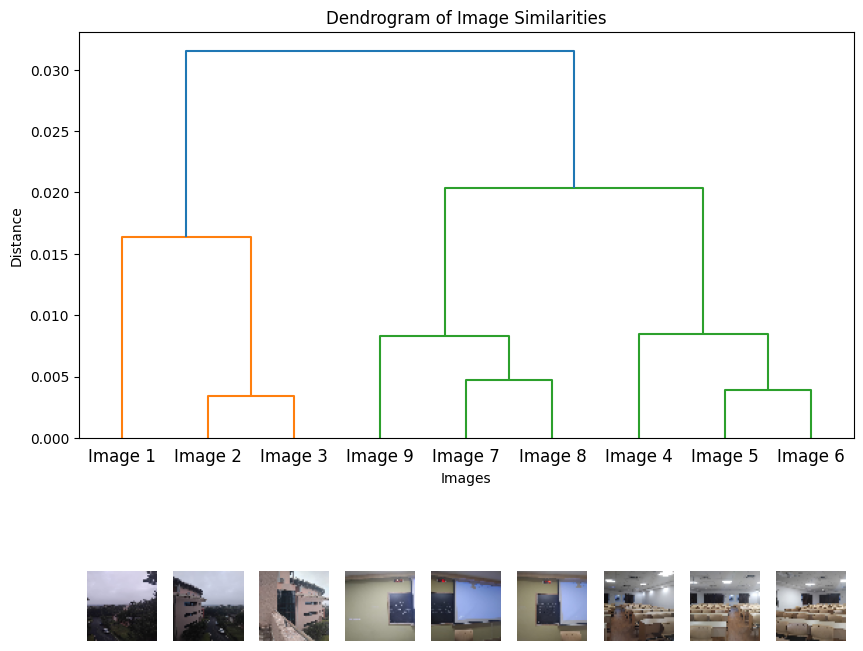

INFO:root:Merged clusters 1 and 2, new cluster: [1, 2]
INFO:root:Merged clusters 3 and 4, new cluster: [4, 5]
INFO:root:Merged clusters 4 and 5, new cluster: [6, 7]
INFO:root:Merged clusters 4 and 5, new cluster: [6, 7, 8]
INFO:root:Merged clusters 2 and 3, new cluster: [3, 4, 5]
INFO:root:Merged clusters 0 and 1, new cluster: [0, 1, 2]


Cluster 1: [1, 2, 3]
Cluster 2: [4, 5, 6]
Cluster 3: [7, 8, 9]
Detected 1659 keypoints in image 1 using SIFT.
Detected 1213 keypoints in image 2 using SIFT.
Detected 2921 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 15455 keypoints in image using SIFT.
Detected 23318 keypoints in image using SIFT.
Preprocessed Stitched image saved to data/gallery_of_3s_outputs
Stitched panorama for cluster 1 saved.
Detected 971 keypoints in image 1 using SIFT.
Detected 1270 keypoints in image 2 using SIFT.
Detected 1391 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 3462 keypoints in image using SIFT.
Detected 4205 keypoints in image using SIFT.
Preprocessed Stitched image saved to data/gallery_of_3s_outputs
Stitched panorama for cluster 2 saved.
Detected 812 keypoints in image 1 using SIFT.
Detected 470 keypoints in image 2 using SIFT.
Detected 357 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 797 keypoints in image using SIFT.

In [15]:

recommended_image_groups = stitcher.recommend_images(
    num_clusters=len(stitcher.input_images) // 3
)
stitcher.stitch_recommended_images(recommended_image_groups)
similarity_matrix = stitcher.compute_pairwise_similarities()

hc = HierarchicalClustering(similarity_matrix)

distance_matrix = hc._convert_similarity_to_distance(similarity_matrix)

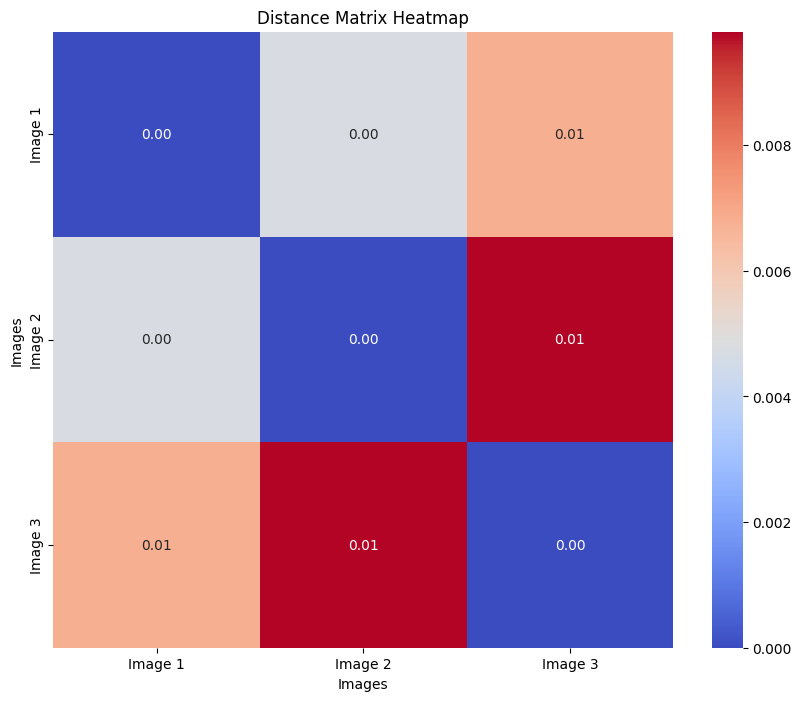

In [16]:
stitcher.plot_distance_matrix_heatmap(distance_matrix)

# Trying with a bigger gallery

In [17]:
# Assuming `stitcher` is an instance of the Stitcher class
stitcher = StitcherWithRecommender()
stitcher.input_dir = "data/gallery"
stitcher.output_dir = "data/gallery_of_3s_outputs"
stitcher.plot = False

stitcher.read_input_dir()
stitcher.detect_keypoints_and_descriptors()

Found 18 images in the input directory.
Detected 1659 keypoints in image 1 using SIFT.
Detected 1118 keypoints in image 2 using SIFT.
Detected 552 keypoints in image 3 using SIFT.
Detected 1213 keypoints in image 4 using SIFT.
Detected 1706 keypoints in image 5 using SIFT.
Detected 1267 keypoints in image 6 using SIFT.
Detected 2921 keypoints in image 7 using SIFT.
Detected 1019 keypoints in image 8 using SIFT.
Detected 892 keypoints in image 9 using SIFT.
Detected 971 keypoints in image 10 using SIFT.
Detected 1270 keypoints in image 11 using SIFT.
Detected 1173 keypoints in image 12 using SIFT.
Detected 1391 keypoints in image 13 using SIFT.
Detected 1411 keypoints in image 14 using SIFT.
Detected 812 keypoints in image 15 using SIFT.
Detected 1275 keypoints in image 16 using SIFT.
Detected 470 keypoints in image 17 using SIFT.
Detected 357 keypoints in image 18 using SIFT.
Feature detection completed.


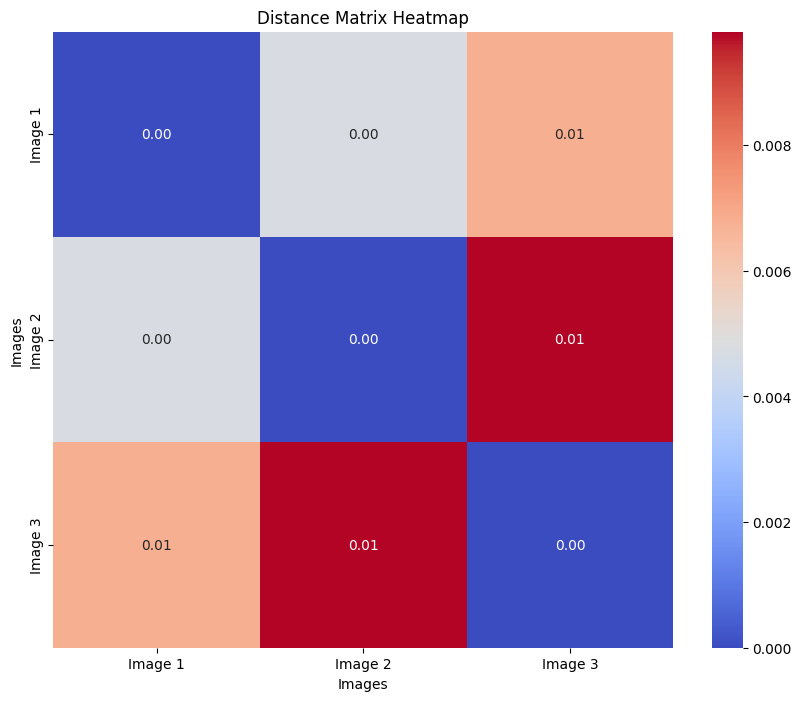

In [18]:

# Plot the heatmap of the initial distance matrix
stitcher.plot_distance_matrix_heatmap(distance_matrix)


Found 36 good matches after ratio test.
Similarity between image 1 and image 2: 36 good matches
Found 17 good matches after ratio test.
Similarity between image 1 and image 3: 17 good matches
Found 200 good matches after ratio test.
Similarity between image 1 and image 4: 200 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 5: 25 good matches
Found 20 good matches after ratio test.
Similarity between image 1 and image 6: 20 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 7: 36 good matches
Found 19 good matches after ratio test.
Similarity between image 1 and image 8: 19 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 9: 21 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 10: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 11: 21 good matches
Found 21 good matches after ratio te

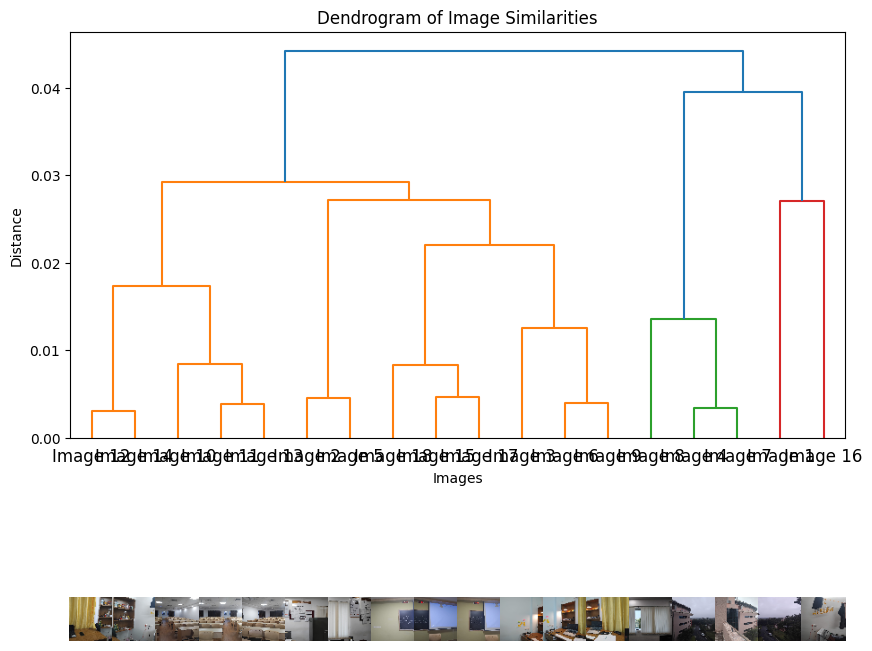

INFO:root:Merged clusters 11 and 13, new cluster: [11, 13]
INFO:root:Merged clusters 3 and 6, new cluster: [3, 6]
INFO:root:Merged clusters 9 and 11, new cluster: [10, 12]
INFO:root:Merged clusters 5 and 7, new cluster: [5, 8]
INFO:root:Merged clusters 1 and 4, new cluster: [1, 4]
INFO:root:Merged clusters 9 and 11, new cluster: [14, 16]
INFO:root:Merged clusters 9 and 11, new cluster: [14, 16, 17]
INFO:root:Merged clusters 6 and 7, new cluster: [9, 10, 12]
INFO:root:Merged clusters 2 and 4, new cluster: [2, 5, 8]
INFO:root:Merged clusters 3 and 4, new cluster: [3, 6, 7]
INFO:root:Merged clusters 4 and 5, new cluster: [9, 10, 12, 11, 13]
INFO:root:Merged clusters 2 and 5, new cluster: [2, 5, 8, 14, 16, 17]


Cluster 1: [1]
Cluster 2: [2, 5]
Cluster 3: [3, 6, 9, 15, 17, 18]
Cluster 4: [4, 7, 8]
Cluster 5: [10, 11, 13, 12, 14]
Cluster 6: [16]


In [19]:
recommended_image_groups = stitcher.recommend_images(
    num_clusters=len(stitcher.input_images) // 3
)